In [ ]:
import keras
import tensorflow as tf
from keras.models import Model
from keras.layers import *

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
IMAGE_SHAPE = (256, 256, 3)

BATCH_SIZE = 30

# DATA

### Loading the Datasets

In [ ]:
!tar -zxvf {'Facades.tar.gz'}

In [ ]:
train = tf.data.Dataset.load('TFRecord/train.tfrecord')
test = tf.data.Dataset.load('TFRecord/test.tfrecord')

### Processing the Data

In [ ]:
def process(image, segment):
    image = (tf.cast(image, tf.float32) / 127.5) - 1.0
    segment = (tf.cast(segment, tf.float32) / 127.5) - 1.0
    return image, segment

train = train.map(process).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
test = test.map(process).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
len(train), len(test)

(84, 17)

### Testing the Dataset

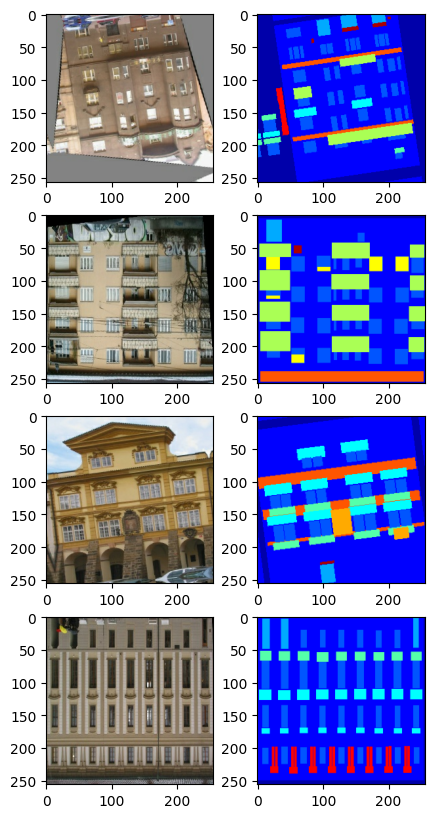

In [ ]:
sample = test.as_numpy_iterator().next()
fig, ax = plt.subplots(4,2, figsize=(5, 10))
for i in range(4):
    ax[i][0].imshow(tf.cast(sample[0][i]*127.5+127.5, dtype=tf.uint8))
    ax[i][1].imshow(tf.cast(sample[1][i]*127.5+127.5, dtype=tf.uint8))

# MODEL

### Building the Model

In [ ]:
class Pix2Pix(Model):
    def __init__(self):
        super(Pix2Pix, self).__init__()

        self.generator = self.build_generator()
        self.discriminator = self.build_discriminator()


    def build_generator(self):
        def double_conv(kernel, inputs):
            x = Conv2D(kernel, 3, activation='relu', padding='same', kernel_initializer = "he_normal")(inputs)
            return Conv2D(kernel, 3, activation='relu', padding='same', kernel_initializer = "he_normal")(x)

        input = Input(shape=(None, None, 3))

        # Encoder part
        x = double_conv(64, input)
        y = MaxPooling2D(2)(x)

        y = double_conv(128, y)
        z = MaxPooling2D(2)(y)

        z = double_conv(256, z)
        v = MaxPooling2D(2)(z)

        v = double_conv(512, v)
        f = MaxPooling2D(2)(v)

        f = double_conv(1024, f)

        # Decoder part
        f = Conv2DTranspose(512, 3, 2, padding='same', kernel_initializer = "he_normal")(f)
        f = Concatenate()([v,f])
        f = double_conv(512, f)

        f = Conv2DTranspose(256, 3, 2, padding='same', kernel_initializer = "he_normal")(f)
        f = Concatenate()([z,f])
        f = double_conv(256, f)

        f = Conv2DTranspose(128, 3, 2, padding='same', kernel_initializer = "he_normal")(f)
        f = Concatenate()([y,f])
        f = double_conv(128, f)

        f = Conv2DTranspose(64, 3, 2, padding='same', kernel_initializer = "he_normal")(f)
        f = Concatenate()([x,f])
        f = double_conv(64, f)

        out = Conv2D(3, 1, padding="same", activation='tanh', kernel_initializer = "he_normal")(f)

        return Model(inputs=input, outputs=out)


    def build_discriminator(self):
        input = Input(shape=IMAGE_SHAPE)

        x = Conv2D(64, 4, 2, padding='same', activation='relu')(input)

        x = Conv2D(128, 4, 2, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        x = Conv2D(256, 4, 2, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        x = Conv2D(512, 4, 2, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        out = Conv2D(1, 4, 1, padding='same', activation='sigmoid')(x)
        return Model(inputs=input, outputs=out)


    def compile(self, gen_optimizer, disc_optimizer, gen_loss, disc_loss):
        super().compile()
        self.gen_opt = gen_optimizer
        self.disc_opt = disc_optimizer
        self.gen_loss = gen_loss
        self.disc_loss = disc_loss


    # Custom train
    def train_step(self, data):
        with tf.GradientTape() as disc_tape, tf.GradientTape() as gen_tape:
            generated_images = self.generator(data[0], training=True)               # Image generation

            real_output = self.discriminator(data[1], training=True)                # Discriminator on target data
            fake_output = self.discriminator(generated_images, training=True)       # Discriminator on generated images

            disc_loss_val = self.disc_loss(real_output, fake_output)                # Calculate discriminator loss
            gen_loss_val = self.gen_loss(fake_output, generated_images, data[1])    # Calculate generator loss

            disc_grads = disc_tape.gradient(disc_loss_val, self.discriminator.trainable_variables)  # Calculate discriminator gradients
            gen_grads = gen_tape.gradient(gen_loss_val, self.generator.trainable_variables)         # Calculate generator gradients

            self.disc_opt.apply_gradients(zip(disc_grads, self.discriminator.trainable_variables))  # Optimize discriminator
            self.gen_opt.apply_gradients(zip(gen_grads, self.generator.trainable_variables))        # Optimize generator

        return {"total_loss":gen_loss_val+disc_loss_val, "gen_loss":gen_loss_val, "disc_loss":disc_loss_val}


    # Custom test
    def test_step(self, data):
        generated_images = self.generator(data[0], training=False)              # Image generation

        real_output = self.discriminator(data[1], training=False)               # Discriminator on target data
        fake_output = self.discriminator(generated_images, training=False)      # Discriminator on generated images

        disc_loss_val = self.disc_loss(real_output, fake_output)                # Calculate discriminator loss
        gen_loss_val = self.gen_loss(fake_output, generated_images, data[1])    # Calculate generator loss

        return {"total_loss":gen_loss_val+disc_loss_val, "gen_loss":gen_loss_val, "disc_loss":disc_loss_val}


    # Saves the Generator
    def save(self, file_path):
        self.generator.save(file_path)


    def call(self, inputs):
        return self.generator(inputs)

In [ ]:
model = Pix2Pix()

### Optimizers and Loss Functions

In [ ]:
gen_opt = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
disc_opt = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)


def disc_loss(disc_real_output, disc_generated_output):
    real_loss = tf.keras.losses.BinaryCrossentropy()(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = tf.keras.losses.BinaryCrossentropy()(tf.zeros_like(disc_generated_output), disc_generated_output)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss


def gen_loss(disc_generated_output, gen_output, target):
    generator_loss = tf.keras.losses.BinaryCrossentropy()(tf.ones_like(disc_generated_output), disc_generated_output)
    l2_loss = tf.keras.losses.MeanSquaredError()(target, gen_output)

    total_loss = generator_loss + 100.0*l2_loss

    return total_loss

In [ ]:
model.compile(gen_opt, disc_opt, gen_loss, disc_loss)

### Training the Model

In [ ]:
model.fit(train, epochs=100, validation_data=test)

### Testing the Model

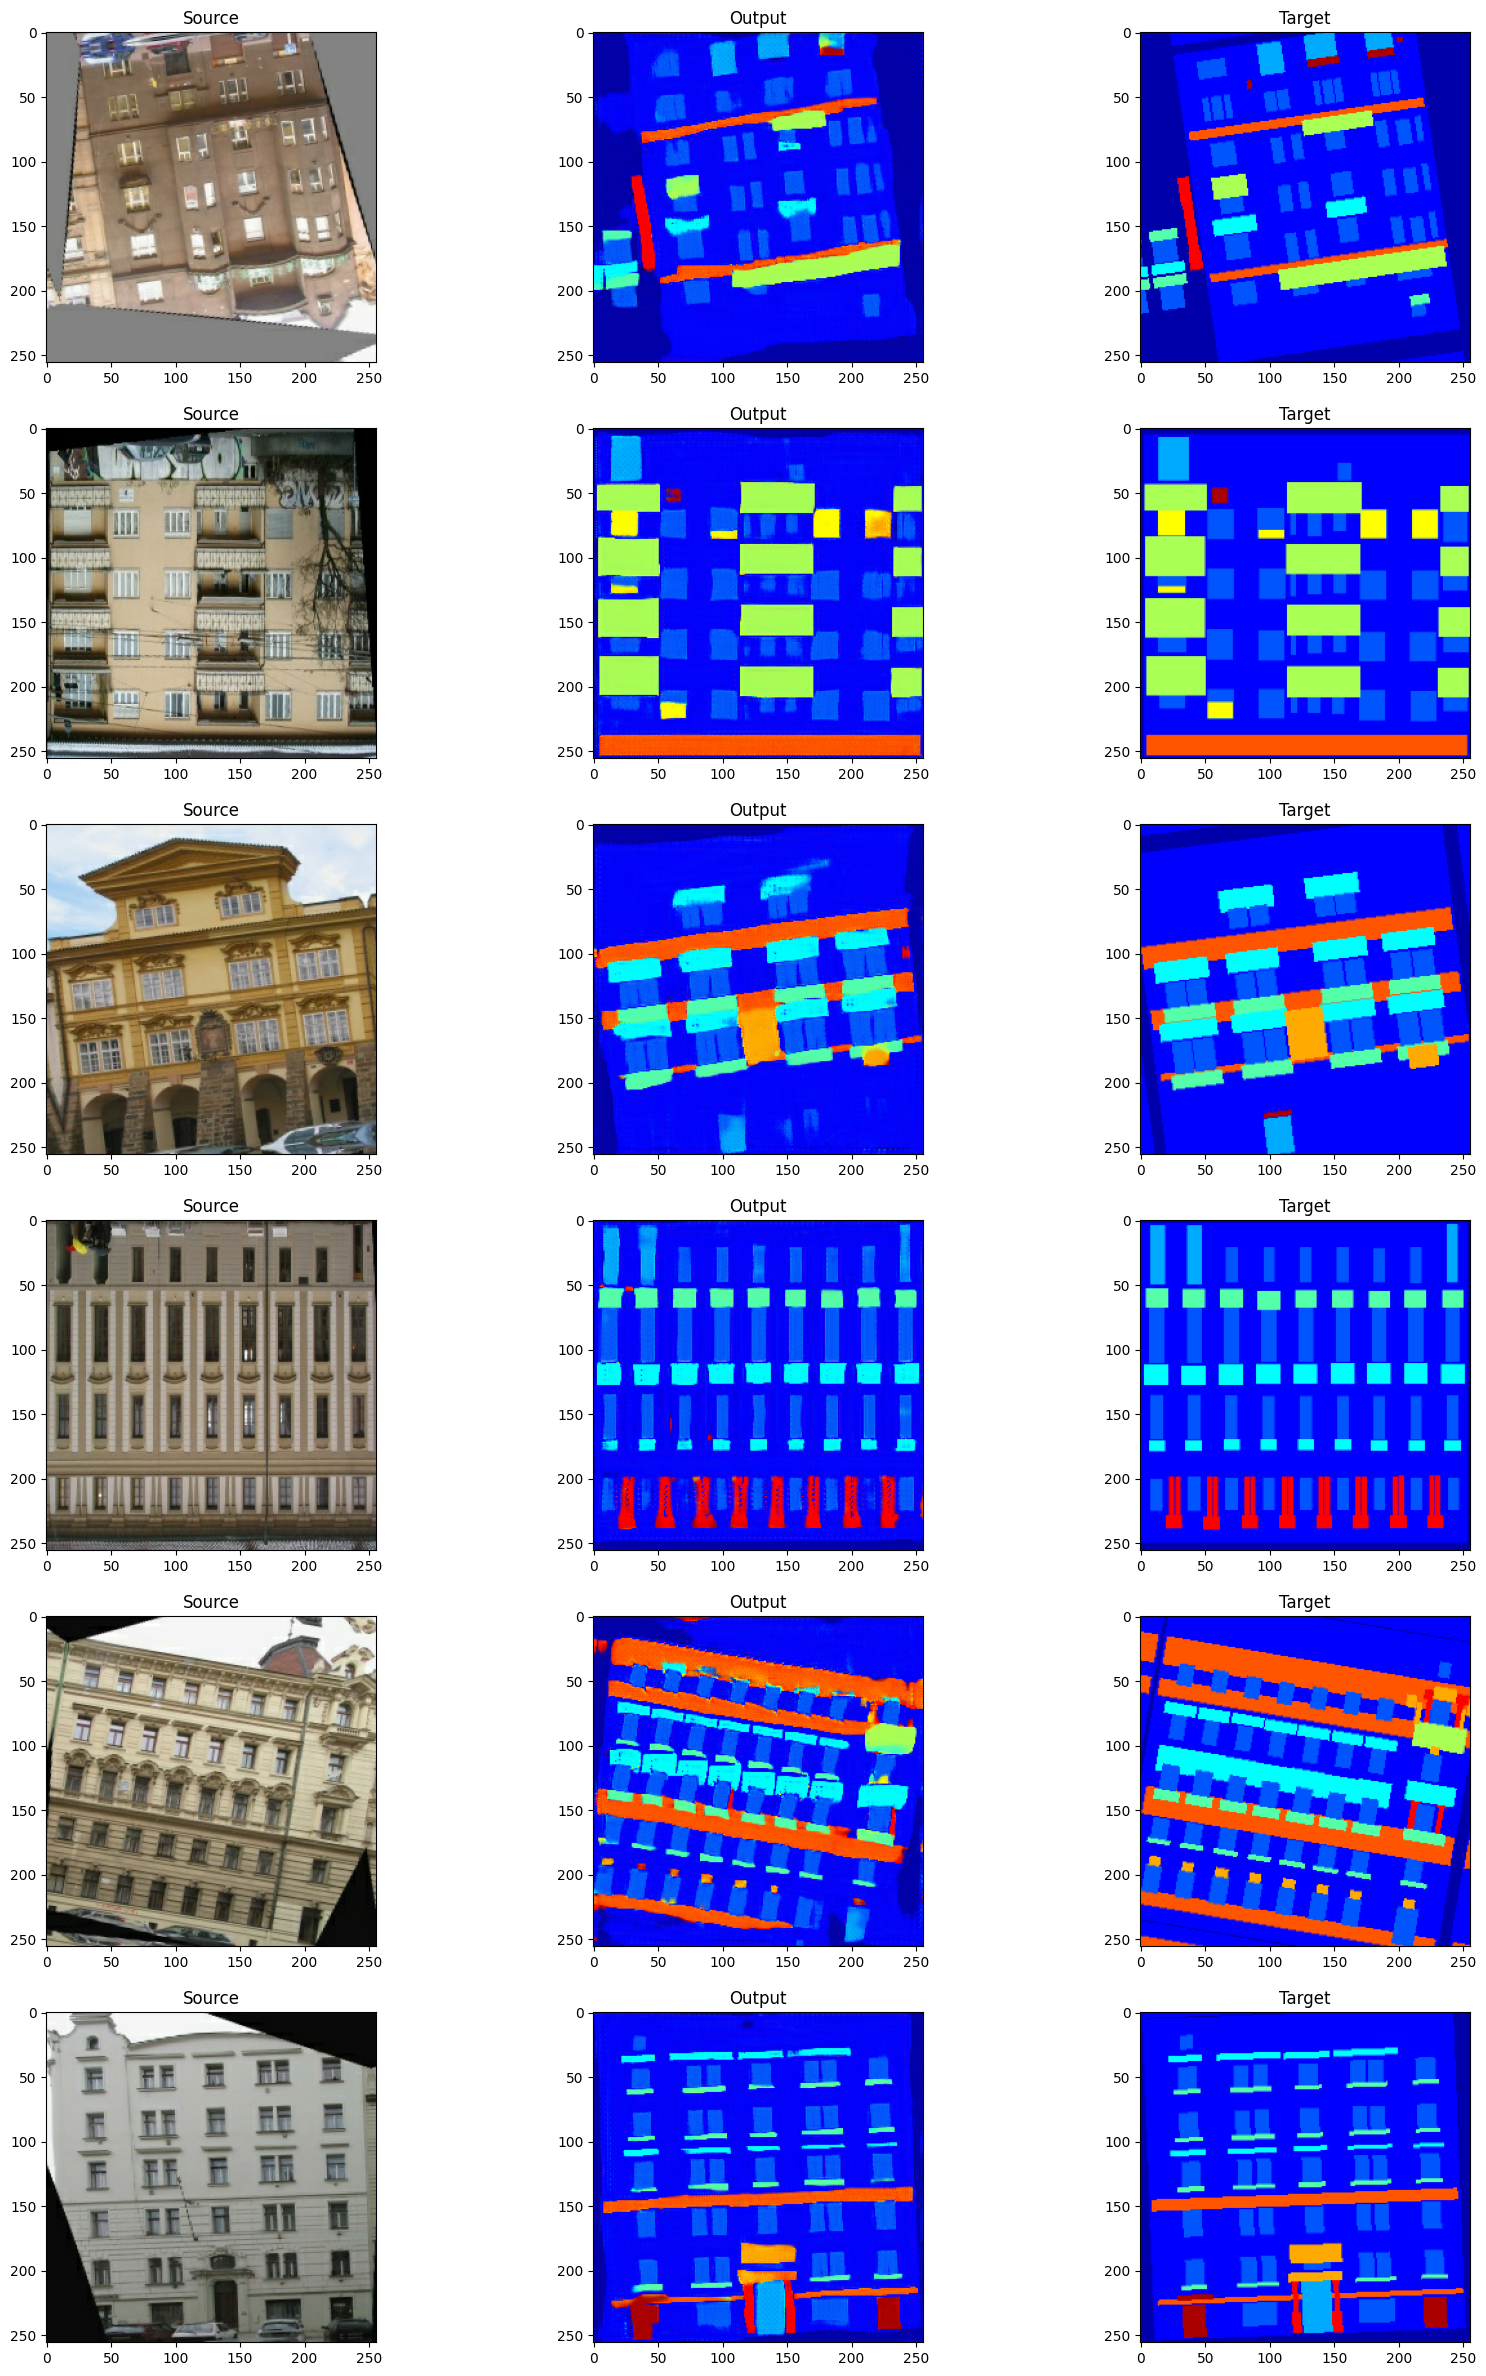

In [ ]:
samples = test.as_numpy_iterator().next()
images = model(samples[0])

fig, ax = plt.subplots(6, 3, figsize=(20, 30))
for i in range(6):
    ax[i][0].imshow(tf.cast(samples[0][i]*127.5+127.5, dtype=tf.uint8))
    ax[i][0].set_title('Source')
    ax[i][1].imshow(tf.cast(images[i]*127.5+127.5, dtype=tf.uint8))
    ax[i][1].set_title('Output')
    ax[i][2].imshow(tf.cast(samples[1][i]*127.5+127.5, dtype=tf.uint8))
    ax[i][2].set_title('Target')

### Saving the Generator

In [ ]:
model.save('Img2Mask.h5')